> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


In [ ]:
# ! pip install langchain-openai langchain-core python-dotenv
# ! pip install langchain


In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Literal
import random
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from getpass import getpass
from dotenv import load_dotenv, find_dotenv


This script securely collect API key (`OPENAI_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


Saved .env


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [2]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

True

This code creates an OpenAI chat model (`ChatOpenAI`) with a fixed temperature of 0, sends it a prompt about planning a short New York trip, and returns the model’s response.  
`response.content` gives the raw text, and `response.pretty_print()` displays the response in a cleaner, formatted way.


In [3]:

chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

**What this code does:**

- Defines a state with one field: `graph_state` (string).
- Creates a node (`node_1`) that prints a message and appends `" world"` to `graph_state`.
- Builds a simple graph: **START → node_1 → END**.
- Compiles the graph and displays its diagram.

**End result:** A minimal LangGraph that updates a string and shows its flow visually.


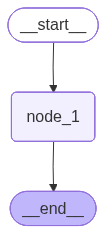

In [4]:


class State(TypedDict):
    graph_state: str

def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" world"}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"graph_state" : "Hello "})

---Node 1---


{'graph_state': 'Hello  world'}

**What this code does:**

- Defines a state with two string fields: `prompt` and `response`.
- `call_model`:
  - Sends `state["prompt"]` to the chat model (`chat.invoke`).
  - Returns the same `prompt` plus the model’s reply in `response`.
- Builds a LangGraph with one node:
  - Flow: **START → call_model → END**.
- Compiles the graph and displays its diagram.

**End result:** A minimal LangGraph that takes a prompt, calls an LLM once, stores the reply in `response`, and shows the graph visually.


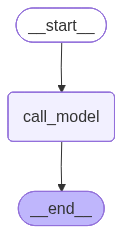

In [6]:

class MiniState(TypedDict):
    prompt: str
    response: str


def call_model(state: MiniState) -> MiniState:
    output = chat.invoke(state["prompt"])  
    return {
        "prompt": state["prompt"],        
        "response": output.content        
    }

g = StateGraph(MiniState)
g.add_node("call_model", call_model)
g.add_edge(START, "call_model")  
g.add_edge("call_model", END)    

graph = g.compile()         
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"prompt" : "What's the capital of France"})

{'prompt': "What's the capital of France",
 'response': 'The capital of France is Paris.'}

**What this code does:**

- Defines a state with one string field: `graph_state`.
- `node_1` prefixes the topic: appends `" AI & jobs: "` to `graph_state`.
- `node_2`, `node_3`, `node_4` each add a different sentence about:
  - `node_2`: job losses / task automation  
  - `node_3`: new AI-related roles  
  - `node_4`: human strengths (creativity, empathy, problem-solving)
- `choose_path` randomly returns `"node_2"`, `"node_3"`, or `"node_4"`.
- Builds a LangGraph:
  - Flow: **START → node_1 → (one of node_2 / node_3 / node_4) → END**.
- Compiles the graph and displays its diagram.

**End result:** A branching LangGraph that starts a sentence about AI & jobs, then randomly follows one of three paths to finish the message.


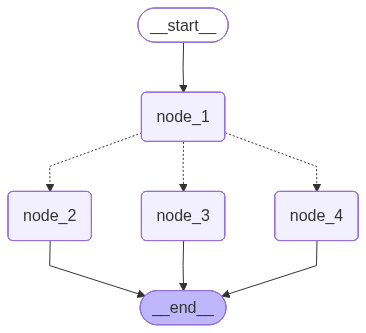

In [8]:

class State(TypedDict):
    graph_state: str
    
def node_1(state: State) -> State:
    print("--- Node 1 ---")
    return {"graph_state": state["graph_state"] + " AI & jobs: "}

def node_2(state: State) -> State:
    print("--- Node 2 (job losses) ---")
    addition = "some repetitive tasks will be automated, so some roles may shrink."
    return {"graph_state": state["graph_state"] + addition}

def node_3(state: State) -> State:
    print("--- Node 3 (new roles) ---")
    addition = "new roles will grow—AI tooling, oversight, data quality, and integration."
    return {"graph_state": state["graph_state"] + addition}

def node_4(state: State) -> State:
    print("--- Node 4 (human strengths) ---")
    addition = "humans lean into creativity, empathy, and messy real-world problem-solving."
    return {"graph_state": state["graph_state"] + addition}

def choose_path(state: State) -> Literal["node_2", "node_3", "node_4"]:
    return random.choice(["node_2", "node_3", "node_4"])    

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)

builder.add_edge(START, "node_1")

builder.add_conditional_edges("node_1", choose_path)

builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"graph_state" : "Hi people, "})

--- Node 1 ---
--- Node 2 (job losses) ---


{'graph_state': 'Hi people,  AI & jobs: some repetitive tasks will be automated, so some roles may shrink.'}